# $\vert 1\rangle$ state decaying
2020/11/20



In [1]:
from pprint import pprint
from datetime import date
from pathlib import Path

from experiments.utils import get_IBM_backend, pickle_load, pickle_dump
from experiments.waiting_duration import EvaluateDelay
from experiments.waiting_duration.benchmarks import prepare_singleBench
from experiments.waiting_duration import execute_bench

from qiskit.visualization import plot_histogram

In [2]:
# user input
backend_name = "ibmq_rome"
nseed = 5
date = "2020-11-20"
initial_layout = [0]

In [3]:
# define backends
backend = get_IBM_backend(backend_name)
simulator = get_IBM_backend("ibmq_qasm_simulator")

# type of experiments 
exp_type = "single_qubit"
initial_state="one_state"

/Users/Yasuhiro/.local/share/virtualenvs/experiments-VWP9UmJy/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Send job

In [4]:
def _save_jobid_path(date, duration_label, initial_state=None, initial_layout=None):
    root = Path(".")
    file_name = date
    if initial_state: 
        file_name += "_"+ initial_state
    
    if initial_layout: 
        file_name += "_"+ duration_label +"_"+ str(initial_layout) +".pickle" 
    else: 
        file_name += "_"+ duration_label +".pickle"
    
    path = root /"job_id" / file_name
        
    return path

In [5]:
# max(dt) = 1E6
jobid_path_e6 = _save_jobid_path(date, "e6", initial_state, initial_layout)
delay_duration_e6 = [0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000]

In [6]:
qc = prepare_singleBench(initial_state, "e6")
execute_bench(
            qc, 
            backend=backend, 
            simulator=simulator, 
            initial_layout=initial_layout, 
            save_path = jobid_path_e6,
            delay_duration_list=delay_duration_e6,
            nseed=nseed, 
)

In [7]:
# max(dt) = 1E5
jobid_path_e5 = _save_jobid_path(date, "e5", initial_state, initial_layout)
delay_duration_e5 = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000]

In [8]:
qc = prepare_singleBench(initial_state, "e5")
execute_bench(
            qc, 
            backend=backend, 
            simulator=simulator, 
            initial_layout=initial_layout, 
            save_path = jobid_path_e5,
            delay_duration_list=delay_duration_e5,
            nseed=nseed, 
)

In [9]:
# max(dt) = 1E4
jobid_path_e4 = _save_jobid_path(date, "e4", initial_state, initial_layout)
delay_duration_e4 = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]

In [10]:
qc = prepare_singleBench(initial_state, "e4")
execute_bench(
            qc, 
            backend=backend, 
            simulator=simulator, 
            initial_layout=initial_layout, 
            save_path = jobid_path_e4,
            delay_duration_list=delay_duration_e4,
            nseed=nseed, 
)

## calculate results

In [11]:
def calculate_results(delay_dutation, job_id_path, save_data_path):
    exp_data = pickle_load(job_id_path)
    job_sim = simulator.retrieve_job(exp_data["simulator"]["job_id"])
    job_delay_before = [backend.retrieve_job(job_id) for job_id in exp_data["delay_before"]["job_id"]]
    job_delay_after = [backend.retrieve_job(job_id) for job_id in exp_data["delay_after"]["job_id"]]
    delay_duration_list = exp_data["delay_duration_list"]

    eval_delay = EvaluateDelay(job_sim, job_delay_before, job_delay_after, delay_duration_list, nseed=nseed, initial_layout=[0])
    counts_before_list_list, counts_after_list_list = eval_delay.evaluate() # return [[seed1 counts_dict], [seed2 counts_dict], ... ]
    
    # calculate mean and sem (standard error mean) of counts
    counts_before_list_mean, counts_before_list_sem = eval_delay.stat(counts_before_list_list)
    counts_after_list_mean, counts_after_list_sem = eval_delay.stat(counts_after_list_list)
    
    # calculate jsd
    before_jsd_all, before_jsd_mean, before_jsd_sem = eval_delay.js_divergence(counts_before_list_list)
    after_jsd_all, after_jsd_mean, after_jsd_sem = eval_delay.js_divergence(counts_after_list_list)
    
    save_data = {
            "before_op": {
                "counts_list_all": counts_before_list_list, 
                "counts_list_mean": counts_before_list_mean, 
                "counts_list_sem": counts_before_list_sem, 
                "jsd_all": before_jsd_all, 
                "jsd_mean": before_jsd_mean, 
                "jsd_sem": before_jsd_sem, 
                },  
            "after_op": {
                "counts_list_all": counts_after_list_list, 
                "counts_list_mean": counts_after_list_mean, 
                "counts_list_sem": counts_after_list_sem, 
                "jsd_all": after_jsd_all, 
                "jsd_mean": after_jsd_mean, 
                "jsd_sem": after_jsd_sem,
                }, 
            "delay_duration": delay_dutation,
            "nseed": nseed
            }
    pickle_dump(save_data, save_data_path)
    return save_data 

In [12]:
def _save_data_path(date, duration_label, initial_state=None, initial_layout=None):
    root = Path(".")
    file_name = date
    if initial_state: 
        file_name += "_"+ initial_state
    
    if initial_layout: 
        file_name += "_"+ duration_label +"_"+ str(initial_layout) +".pickle" 
    else: 
        file_name += "_"+ duration_label +".pickle"
    
    path = root /"data/pickle" / file_name
        
    return path

In [13]:
savedata_path_e6 = _save_data_path(date, "e6", initial_state, initial_layout)
e6 = calculate_results(delay_duration_e6, jobid_path_e6, savedata_path_e6)
pprint(e6)

{'after_op': {'counts_list_all': [[{'0': 352, '1': 7840},
                                   {'0': 386, '1': 7806},
                                   {'0': 416, '1': 7776},
                                   {'0': 419, '1': 7773},
                                   {'0': 375, '1': 7817}],
                                  [{'0': 2356, '1': 5836},
                                   {'0': 1347, '1': 6845},
                                   {'0': 1279, '1': 6913},
                                   {'0': 1255, '1': 6937},
                                   {'0': 1517, '1': 6675}],
                                  [{'0': 3447, '1': 4745},
                                   {'0': 2085, '1': 6107},
                                   {'0': 2091, '1': 6101},
                                   {'0': 2051, '1': 6141},
                                   {'0': 2384, '1': 5808}],
                                  [{'0': 4147, '1': 4045},
                                   {'0': 2727, '1': 5465},

In [14]:
savedata_path_e5 = _save_data_path(date, "e5", initial_state, initial_layout)
e5 = calculate_results(delay_duration_e5, jobid_path_e5, savedata_path_e5)
pprint(e5)

{'after_op': {'counts_list_all': [[{'0': 283, '1': 7909},
                                   {'0': 292, '1': 7900},
                                   {'0': 252, '1': 7940},
                                   {'0': 239, '1': 7953},
                                   {'0': 268, '1': 7924}],
                                  [{'0': 420, '1': 7772},
                                   {'0': 435, '1': 7757},
                                   {'0': 434, '1': 7758},
                                   {'0': 428, '1': 7764},
                                   {'0': 403, '1': 7789}],
                                  [{'0': 575, '1': 7617},
                                   {'0': 537, '1': 7655},
                                   {'0': 543, '1': 7649},
                                   {'0': 567, '1': 7625},
                                   {'0': 511, '1': 7681}],
                                  [{'0': 767, '1': 7425},
                                   {'0': 731, '1': 7461},
           

In [15]:
savedata_path_e4 = _save_data_path(date, "e4", initial_state, initial_layout)
e4 = calculate_results(delay_duration_e4, jobid_path_e4, savedata_path_e4)
pprint(e4)

{'after_op': {'counts_list_all': [[{'0': 294, '1': 7898},
                                   {'0': 285, '1': 7907},
                                   {'0': 253, '1': 7939},
                                   {'0': 241, '1': 7951},
                                   {'0': 282, '1': 7910}],
                                  [{'0': 291, '1': 7901},
                                   {'0': 305, '1': 7887},
                                   {'0': 309, '1': 7883},
                                   {'0': 301, '1': 7891},
                                   {'0': 320, '1': 7872}],
                                  [{'0': 278, '1': 7914},
                                   {'0': 311, '1': 7881},
                                   {'0': 324, '1': 7868},
                                   {'0': 324, '1': 7868},
                                   {'0': 295, '1': 7897}],
                                  [{'0': 321, '1': 7871},
                                   {'0': 395, '1': 7797},
           

In [16]:
from matplotlib import pyplot as plt
import numpy as np

In [17]:
def _save_plot_path(date, duration_label, initial_state=None, initial_layout=None):
    root = Path(".")
    file_name = date
    if initial_state: 
        file_name += "_"+ initial_state
    
    if initial_layout: 
        file_name += "_"+ duration_label +"_"+ str(initial_layout) +".png" 
    else: 
        file_name += "_"+ duration_label +".png"
    
    path = root / "data/plot" / file_name
    return path
    
def plot_decay(data, delay_duration, save_plot_path):
    duration = data["delay_duration"]
    jsd_bef = data["before_op"]["jsd_mean"]
    sem_bef = data["before_op"]["jsd_sem"]
    jsd_aft = data["after_op"]["jsd_mean"]
    sem_aft = data["after_op"]["jsd_sem"]

    sigma = 3
    # y軸方向にのみerrorbarを表示
    plt.figure(figsize=(10,7))
    plt.errorbar(delay_duration, jsd_bef, yerr = [sigma*sem for sem in sem_bef], capsize=3, fmt='.', markersize=10, color='#FF6E33')
    plt.errorbar(delay_duration, jsd_aft, yerr = [sigma*sem for sem in sem_aft], capsize=3, fmt='.', markersize=10, color='#33FF80')
    plt.xticks(duration, rotation=30)
    plt.xlabel('Delay duration', fontsize=20)
    plt.ylabel('JSD', fontsize=20)
    plt.savefig(save_plot_path)

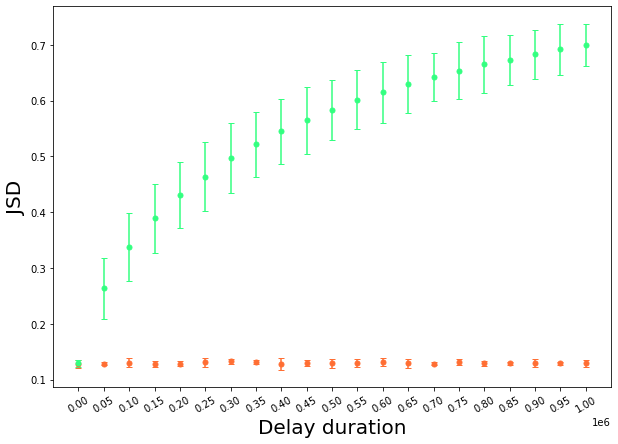

In [18]:
save_plot_path_e6 = _save_plot_path(date, "e6", initial_state, initial_layout)
plot_decay(e6, delay_duration_e6, save_plot_path_e6)

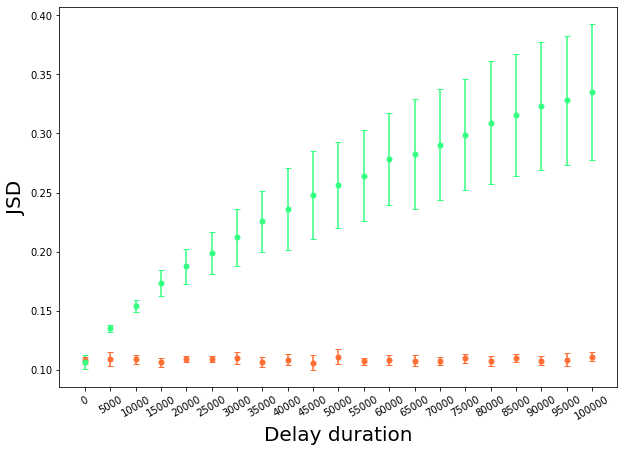

In [19]:
save_plot_path_e5 = _save_plot_path(date, "e5", initial_state, initial_layout)
plot_decay(e5, delay_duration_e5, save_plot_path_e5)

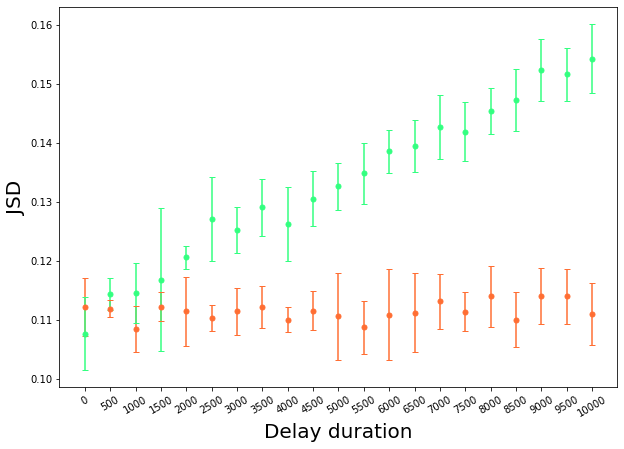

In [20]:
save_plot_path_e4 = _save_plot_path(date, "e4", initial_state, initial_layout)
plot_decay(e4, delay_duration_e4, save_plot_path_e4)